In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from time import time
import os
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
data_dir = "/home/alex/Projects/GRAN_social/exp/GRAN"
os.chdir(data_dir)

def load_from_constructed(path, keep_largest = False, min_size = None):
    graphs = []
    for f in os.listdir(path):
        g = nx.read_edgelist(os.path.join(path, f))
        if min_size is not None:
            if g.number_of_nodes() >= min_size:
                graphs.append(g)
        else:
            graphs.append(g)
    
    if keep_largest:
        out_graphs = []
        for gg in graphs:
            CGs = [gg.subgraph(c) for c in nx.connected_components(gg)]
            CGs = sorted(CGs, key=lambda x: x.number_of_nodes(), reverse=True)
            if len(CGs) != 0:
                out_graphs += [CGs[0]]

        return out_graphs
    else:
        return graphs
    
def num_uncon(G):
    CGs = [G.subgraph(c) for c in nx.connected_components(G)]
    return len(CGs)

def comp_id(G):
    CGs = [G.subgraph(c) for c in nx.connected_components(G)]
    con_dict = {}
    
    for i, cg in enumerate(CGs):
        for node in cg.nodes():
            con_dict[node] = i
    return con_dict

In [3]:
import networkit as nk
from math import log2
from networkit.generators import RmatGenerator
def learn_and_generate(G):

    nodes = sorted(list(G.nodes()))
    N = len(list(G.nodes()))
    A = nx.to_numpy_array(G, nodelist=nodes)
    edge_total = np.sum(A)
    
    scale = np.around(log2(N), decimals = 0)
    to_remove = 2**scale - N
    
    if to_remove <= 0:
        scale = scale + 1
        to_remove = 2**scale - N
    # print(N)
    # print(scale)
    # print(2**scale)
    
    
    # print(f"Adjacency:\n{A}")


    edgefactor = (edge_total / 2)  / N

    halfN = int(N/2)

    top_left = np.sum(A[:halfN, :halfN]) / edge_total
    top_right = np.sum(A[:halfN, halfN:]) / edge_total
    bottom_left = np.sum(A[halfN:, :halfN]) / edge_total
    bottom_right = np.sum(A[halfN:, halfN:]) / edge_total

    # print(f"Probabilities:\n"
    #       f"{top_left:.2f} {top_right:.2f}\n"
    #       f"{bottom_left:.2f} {bottom_right:.2f}")
    
    # print(scale,
    #         edgefactor,
    #         top_left,
    #         top_right,
    #         bottom_left,
    #         bottom_right,
    #          to_remove)
    
    generator = nk.generators.RmatGenerator(scale,
                                            edgefactor,
                                            top_left,
                                            top_right,
                                            bottom_left,
                                            bottom_right,
                                            reduceNodes=to_remove)


    return nk.nxadapter.nk2nx(generator.generate())

In [4]:
facebook_graphs_real = load_from_constructed(os.path.join(os.path.join(data_dir, "FB_LARGE"), "sample_graphs"))
facebook_graphs_gen  = load_from_constructed(os.path.join(os.path.join(data_dir, "FB_LARGE"), "pred_graphs"))

# twitch_graphs_real = load_from_constructed(os.path.join(os.path.join(data_dir, "TWITCH"), "sample_graphs"))
# twitch_graphs_gen  = load_from_constructed(os.path.join(os.path.join(data_dir, "TWITCH"), "pred_graphs"))

# github_graphs_real = load_from_constructed(os.path.join(os.path.join(data_dir, "GIT"), "sample_graphs"))
# github_graphs_gen  = load_from_constructed(os.path.join(os.path.join(data_dir, "GIT"), "pred_graphs"))

# deezer_graphs_real = load_from_constructed(os.path.join(os.path.join(data_dir, "DEEZER_EGO"), "sample_graphs"), min_size = 11)
# deezer_graphs_gen  = load_from_constructed(os.path.join(os.path.join(data_dir, "DEEZER_EGO"), "pred_graphs"))

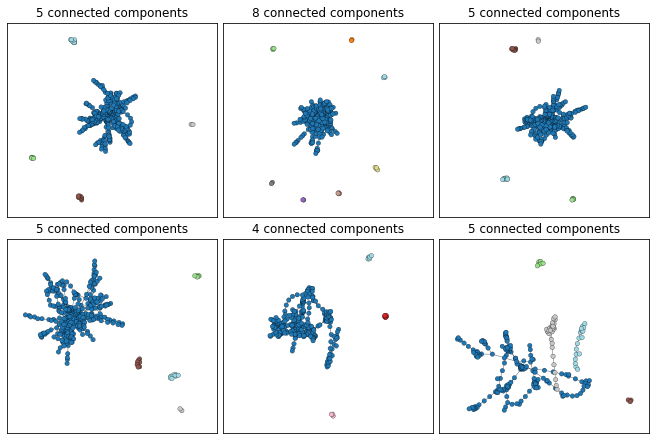

In [10]:


fig, axes = plt.subplots(ncols = 3, nrows=2, figsize = (9,6), constrained_layout = True)
graphs = facebook_graphs_gen
# shuffle(graphs)
axes = list(axes[0]) + list(axes[1]) 
for ind_col, ax in enumerate(axes):

    ax.axis('equal')
    
    graph_index = np.random.randint(0,39)
    
    G = graphs[graph_index]
    # pos = nx.nx_pydot.graphviz_layout(G, prog="sfdp")
    pos = nx.spring_layout(G, iterations = 100)
    # pos = nx.kamada_kawai_layout(G)

    clustering = nx.degree(G)
    
    con_dict = comp_id(G)
    colors = []
    
    for n in G.nodes():
        colors.append(con_dict[n])

    # print(clustering)

    # colours = []
    # for c in clustering:
    #     colours.append(clustering[c])
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=20,
        node_color= colors, #'#336699',
        alpha=1,
        linewidths=0.25,
        edgecolors="black",
        cmap = "tab20",
        ax = ax)
    ax.grid(False)
    # ax.axis('off')
    ax.set_title(f"{num_uncon(G)} connected components")
    nx.draw_networkx_edges(G, pos,  alpha=0.75, width=0.4, node_size = 10, ax = ax)
# plt.show()
plt.savefig("unconnected_components.pdf", dpi = 300)

In [ ]:
# from random import shuffle
# shuffle(deezer_graphs_real)
# graph_datasets = [deezer_graphs_real[:100], facebook_graphs_real, twitch_graphs_real, github_graphs_real]

In [ ]:
# from tqdm import tqdm
# def time_rmat(dataset):
#     times = []
#     for g in tqdm(dataset):
#         start = time()
#         _ = learn_and_generate(g)
#         times.append(time() - start)
        
#     return np.mean(times)

In [ ]:
# rmat_times = [time_rmat(dset) for dset in graph_datasets]
# rmat_times